# Topic Extraction in RSS-Feed Corpus

- Author:      Johannes Maucher
- Last update: 2018-11-16

In the [notebook 01gensimDocModelSimple](02gensimDocModelSimple.ipynb) the concepts of dictionaries, document models, tf-idf and similarity have been described using an example of a samll document collection. Moreover, in [notebook 02LatentSemanticIndexing](02LatentSemanticIndexing.ipynb) LSI based topic extraction and document clustering have also been introduced by a small playground example.

The current notebook applies these concepts to a real corpus of RSS-Feeds, which has been generated and accessed in previous notebooks of this lecture:

## Read documents from a corpus 

The contents of the RSS-Fedd corpus are imported by NLTK's `CategorizedPlaintextCorpusReader` as already done in previous notebooks of this lecture:

In [8]:
#!pip install wordcloud

In [3]:
from nltk.corpus.reader import CategorizedPlaintextCorpusReader
from nltk.corpus import stopwords
stopwordlist=stopwords.words('english')
from wordcloud import WordCloud

rootDir="../Data/ENGLISH"
filepattern=r"(?!\.)[\w_]+(/RSS/FeedText/)[\w-]+/[\w-]+\.txt"
#filepattern=r"(?!\.)[\w_]+(/RSS/FullText/)[\w-]+/[\w-]+\.txt"
catpattern=r"([\w_]+)/.*"
rssreader=CategorizedPlaintextCorpusReader(rootDir,filepattern,cat_pattern=catpattern)

In [4]:
singleDoc=rssreader.paras(categories="TECH")[0]
print("The first paragraph:\n",singleDoc)
print("Number of paragraphs in the corpus: ",len(rssreader.paras(categories="TECH")))

The first paragraph:
 [['Radar', 'trends', 'to', 'watch', ':', 'May', '2022', 'April', 'was', 'the', 'month', 'for', 'large', 'language', 'models', '.'], ['There', 'was', 'one', 'announcement', 'after', 'another', ';', 'most', 'new', 'models', 'were', 'larger', 'than', 'the', 'previous', 'ones', ',', 'several', 'claimed', 'to', 'be', 'significantly', 'more', 'energy', 'efficient', '.'], ['The', 'largest', '(', 'as', 'far', 'as', 'we', 'know', ')', 'is', 'Google', '’', 's', 'GLAM', ',', 'with', '1', '.', '2', 'trillion', 'parameters', '–', 'but', 'requiring', 'significantly', 'less', 'energy', 'to', 'train', 'than', 'GPT', '-', '3', '.'], ['Chinchilla', 'has', '[…]']]
Number of paragraphs in the corpus:  40


In [5]:
techdocs=[[w.lower() for sent in singleDoc for w in sent if (len(w)>1 and w.lower() not in stopwordlist)] for singleDoc in rssreader.paras(categories="TECH")]
print("Number of documents in category Tech: ",len(techdocs))

Number of documents in category Tech:  40


In [6]:
generaldocs=[[w.lower() for sent in singleDoc for w in sent if (len(w)>1 and w.lower() not in stopwordlist)] for singleDoc in rssreader.paras(categories="GENERAL")]
print("Number of documents in category General: ",len(generaldocs))

Number of documents in category General:  40


In [7]:
alldocs=techdocs+generaldocs
print("Total number of documents: ",len(alldocs))

Total number of documents:  80


### Remove duplicate news

In [8]:
def removeDuplicates(nestedlist):
    listOfTuples=[tuple(liste) for liste in nestedlist]
    uniqueListOfTuples=list(set(listOfTuples))
    return [list(menge) for menge in uniqueListOfTuples]

In [9]:
techdocs=removeDuplicates(techdocs)
generaldocs=removeDuplicates(generaldocs)
alldocs=removeDuplicates(alldocs)
print("Number of unique documents in category Tech: ",len(techdocs))
print("Number of unique documents in category General: ",len(generaldocs))
print("Total number of unique documents: ",len(alldocs))

Number of unique documents in category Tech:  20
Number of unique documents in category General:  18
Total number of unique documents:  38


In [10]:
alltechString=" ".join([w for doc in techdocs for w in doc])
print(len(alltechString))
allgeneralString=" ".join([w for doc in generaldocs for w in doc])
print(len(allgeneralString))

7364
2146


(-0.5, 399.5, 199.5, -0.5)

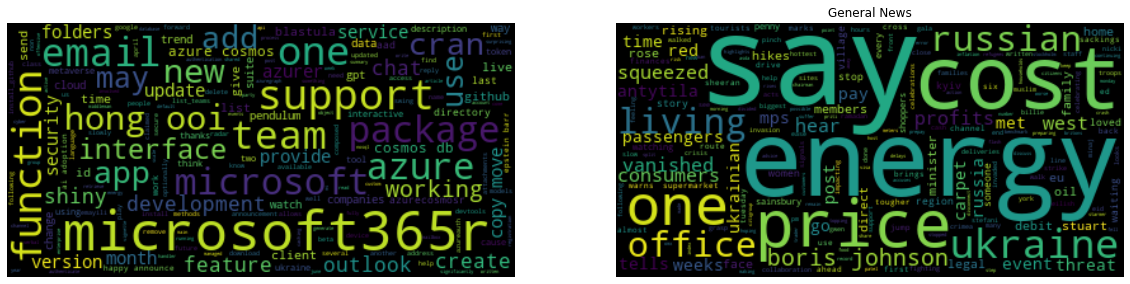

In [11]:
wordcloudTech=WordCloud().generate(alltechString)
wordcloudGeneral=WordCloud().generate(allgeneralString)
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,18))
plt.title("Tech News")
plt.subplot(1,2,1)
plt.imshow(wordcloudTech, interpolation='bilinear')
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(wordcloudGeneral, interpolation='bilinear')
plt.title("General News")
plt.axis("off")

## Gensim-representation of imported RSS-feeds 

In [22]:
from gensim import corpora, models, similarities
dictionary = corpora.Dictionary(alldocs)
dictionary.save('../Data/feedwordsDE.dict') # store the dictionary, for future reference
print(len(dictionary))

820


In [27]:
import random

first_doc = techdocs[0]
print(first_doc)

first_vec = dictionary.doc2bow(first_doc)
print(f"Sparse BoW representation of single document: {first_vec}")

for word in random.choices(first_doc, k=3):
    print(f"Index of word {word} is {dictionary.token2id[word]}")

['recommendations', 'us', 'live', 'household', 'communal', 'device', 'like', 'amazon', 'echo', 'google', 'home', 'hub', 'probably', 'use', 'play', 'music', 'live', 'people', 'may', 'find', 'time', 'spotify', 'pandora', 'algorithm', 'seems', 'know', 'well', 'find', 'songs', 'creeping', '[…]']
Sparse BoW representation of single document: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1)]
Index of word echo is 6
Index of word device is 5
Index of word spotify is 24


Sparse BoW representation of entire tech-corpus and entire general-news-corpus: 

In [28]:
techcorpus = [dictionary.doc2bow(doc) for doc in techdocs]
generalcorpus = [dictionary.doc2bow(doc) for doc in generaldocs]

In [29]:
print(generaldocs[:3])

[['women', 'waiting', 'hear', 'vanished', 'loved', 'ones', 'stop', 'village', 'region', 'west', 'kyiv', 'hear', 'story', 'someone', 'vanished'], ['sainsbury', 'says', 'shoppers', 'watching', 'every', 'penny', 'supermarket', 'profits', 'jump', 'warns', 'tougher', 'times', 'ahead', 'consumers', 'finances', 'squeezed'], ['brings', 'back', 'passengers', 'cross', 'channel', 'route', 'sackings', 'tuesday', 'marks', 'first', 'time', 'drive', 'passengers', 'tourists', 'use', 'almost', 'six', 'weeks']]


## Find similiar documents

In [39]:
index = similarities.SparseMatrixSimilarity(techcorpus, num_features=len(dictionary))

In [40]:
sims = index[first_vec]
#print(list(enumerate(sims)))
simlist = sims.argsort()
print(simlist)
mostSimIdx=simlist[-2]

[ 2  7 18  4 11  5  9  8  6 12 16 19 17  3 14 13 10 15  1  0]


In [41]:
print("Refernce document is:\n",first_doc)
print("Most similar document:\n",techdocs[mostSimIdx])

Refernce document is:
 ['microsoft365r', 'outlook', 'support', 'cran', 'hong', 'ooi', 'happy', 'announce', 'microsoft365r', 'cran', 'outlook', 'email', 'support', 'quick', 'summary', 'new', 'features', 'send', 'reply', 'forward', 'emails', 'optionally', 'composed', 'blastula', 'emayili', 'copy', 'move', 'emails', 'folders', 'create', 'delete', 'copy', 'move', 'folders', 'add', 'remove', 'download', 'attachments', 'sample', 'write', 'email', 'using', 'blastula', 'library', 'microsoft365r', '1st', 'one', 'personal', 'microsoft', 'account', '2nd', 'work', 'school', 'account', 'outl']
Most similar document:
 ['outlook', 'client', 'support', 'microsoft365r', 'available', 'beta', 'test', 'hong', 'ooi', 'announcement', 'beta', 'outlook', 'email', 'client', 'part', 'microsoft365r', 'package', 'install', 'github', 'repository', 'devtools', '::', 'install_github', '("', 'azure', 'microsoft365r', '")', 'client', 'provides', 'following', 'features', 'send', 'reply', 'forward', 'emails', 'optionall

## Find topics by Latent Semantic Indexing (LSI)
### Generate tf-idf model of corpus

In [42]:
tfidf = models.TfidfModel(techcorpus)
corpus_tfidf = tfidf[techcorpus]
print("Display TF-IDF- Model of first 2 documents of the corpus")
for doc in corpus_tfidf[:2]:
    print(doc)

Display TF-IDF- Model of first 2 documents of the corpus
[(13, 0.055648773453563255), (19, 0.15879721214500278), (20, 0.15879721214500278), (21, 0.31759442429000556), (22, 0.08531278174327886), (23, 0.10056217885820973), (24, 0.12205499694414082), (25, 0.24410999388828164), (26, 0.12205499694414082), (27, 0.24410999388828164), (28, 0.1469688608034478), (29, 0.08531278174327886), (30, 0.12205499694414082), (31, 0.12205499694414082), (32, 0.17062556348655772), (33, 0.24410999388828164), (34, 0.12205499694414082), (35, 0.08531278174327886), (36, 0.24410999388828164), (37, 0.12205499694414082), (38, 0.10056217885820973), (39, 0.04857056654241692), (40, 0.15879721214500278), (41, 0.08531278174327886), (42, 0.19145989097204336), (43, 0.24410999388828164), (44, 0.055648773453563255), (45, 0.04857056654241692), (46, 0.12205499694414082), (47, 0.15879721214500278), (48, 0.20112435771641946), (49, 0.15879721214500278), (50, 0.15879721214500278), (51, 0.12205499694414082), (52, 0.1220549969441408

### Generate LSI model from tf-idf model

In [43]:
techdictionary = corpora.Dictionary(techdocs)

In [44]:
NumTopics=20
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=NumTopics) # initialize an LSI transformation

In [45]:
corpus_lsi = lsi[corpus_tfidf]

Display first 10 topics:

In [46]:
lsi.print_topics(10)

[(0,
  '-0.349*"microsoft365r" + -0.189*"microsoft" + -0.156*"outlook" + -0.155*"move" + -0.155*"emails" + -0.155*"folders" + -0.155*"copy" + -0.142*"teams" + -0.133*"365" + -0.132*"email"'),
 (1,
  '0.195*"move" + 0.195*"folders" + 0.195*"emails" + 0.195*"copy" + 0.174*"client" + -0.163*"app" + 0.150*"blastula" + 0.144*"outlook" + 0.137*"account" + -0.125*"shiny"'),
 (2,
  '-0.180*"gpt" + -0.179*"models" + -0.179*"significantly" + -0.179*"energy" + -0.144*"tool" + -0.144*"verbal" + -0.144*"descriptions" + -0.144*"surprising" + -0.133*"metaverse" + -0.128*"2022"'),
 (3,
  '-0.225*"packages" + -0.215*"azurer" + 0.188*"azure" + 0.159*"cosmos" + 0.159*"db" + -0.156*"update" + -0.126*"june" + -0.126*"caching" + 0.119*"azurecosmosr" + 0.114*"functions"'),
 (4,
  '-0.204*"teams" + -0.181*"team" + 0.145*"app" + 0.137*"metaverse" + 0.135*"azure" + -0.135*"()" + -0.133*"list_teams" + -0.126*"chats" + -0.116*"list" + 0.115*"cosmos"'),
 (5,
  '0.254*"metaverse" + 0.164*"could" + 0.163*"live" + 0.

### Determine the most relevant documents for a selected topic

Generate a numpy array `docTopic`. The entry in row $i$, column $j$ of this array is the relevance value for topic $j$ in document $i$.

In [47]:
import numpy as np
numdocs= len(corpus_lsi)
docTopic=np.zeros((numdocs,NumTopics))

In [48]:
for d,doc in enumerate(corpus_lsi): # both bow->tfidf and tfidf->lsi transformations are actually executed here, on the fly
    for t,top in enumerate(doc):
        docTopic[d,t]=top[1]
print(docTopic.shape)
print(docTopic)

(20, 20)
[[-6.30607635e-01  5.36371130e-01 -5.55603925e-02 -1.10429913e-02
   1.02211588e-01 -4.19538185e-02  5.23341721e-02 -2.01324536e-02
   9.36476226e-03  1.48590022e-02 -5.64484933e-02 -1.76516387e-02
  -2.52711931e-02  3.12620379e-02  3.97842969e-03  9.22752537e-03
  -2.30506582e-02 -6.48237130e-02 -2.02715658e-01 -4.94701015e-01]
 [-6.04091276e-01  5.73628893e-01 -6.18943219e-02  6.50059353e-02
   1.36255030e-01 -6.08886307e-02  1.62551604e-02 -4.69463769e-02
   1.80244057e-03  2.64716158e-02 -4.91570907e-02  4.11850780e-04
  -1.38490360e-02  2.17868203e-02 -5.68861208e-02 -1.21444467e-03
   1.17206225e-03 -1.12703328e-02  8.58949481e-02  5.08620690e-01]
 [-3.03491346e-02 -3.01121930e-02 -6.77552212e-02  3.23638202e-02
  -4.63767220e-02  1.53101006e-01  1.56397015e-01 -7.49283302e-01
   8.67874972e-02  3.13360382e-02  1.88340293e-01  5.51809912e-01
   4.37718308e-02 -1.52561947e-01 -5.61926302e-02  5.06158688e-02
  -2.66355793e-02 -7.51413228e-03  2.26857889e-02 -1.96536220e-02

Select an arbitrary topic-id and determine the documents, which have the highest relevance value for this topic:

In [49]:
topicId=7 #select an arbitrary topic-id
topicRelevance=docTopic[:,topicId]

In [50]:
docsoftopic= np.array(topicRelevance).argsort()
relevanceValue= np.sort(topicRelevance)
print(docsoftopic) #most relevant document for selected topic is at first position
print(relevanceValue) #highest relevance document/topic-relevance-value is at first position

[ 2  7 17 13 16  9  1  3  0  6  4 12 15 19 14  8 18 11 10  5]
[-0.7492833  -0.48423739 -0.11044728 -0.09074076 -0.06701498 -0.05548321
 -0.04694638 -0.04489727 -0.02013245  0.00272558  0.02267561  0.02337849
  0.05623017  0.06121795  0.08802603  0.09857504  0.12701122  0.20098731
  0.23175794  0.23837439]


In [51]:
TOP=8
print("Selected Topic:\n",lsi.show_topic(topicId))
print("#"*50)
print("Docs with the highest negative value w.r.t the selected topic")
for idx in docsoftopic[:TOP]:
    print("-"*20)
    print(idx,"\n",techdocs[idx])
print("#"*50)
print("Docs with the highest positive value w.r.t the selected topic")
for idx in docsoftopic[-TOP:]:
    print("-"*20)
    print(idx,"\n",techdocs[idx])

Selected Topic:
 [('party', -0.2488676878930281), ('middleman', -0.2488676878930281), ('two', -0.24596576983629964), ('ukraine', -0.2134234697117422), ('cyber', -0.1422823131411615), ('offensive', -0.1422823131411615), ('building', -0.12443384394651405), ('actually', -0.12443384394651405), ('despite', -0.12443384394651405), ('comes', -0.12443384394651405)]
##################################################
Docs with the highest negative value w.r.t the selected topic
--------------------
2 
 ['building', 'better', 'middleman', 'comes', 'mind', 'hear', 'term', 'two', 'sided', 'market', '?”', 'maybe', 'imagine', 'party', 'needs', 'something', 'interact', 'party', 'provides', 'despite', 'number', 'two', 'name', 'actually', 'someone', 'else', 'involved', 'middleman', 'entity', 'sits', 'parties', 'make', '[…]']
--------------------
7 
 ['day', 'kyiv', 'experience', 'working', 'ukraine', 'offensive', 'cyber', 'team', 'jeffrey', 'carrmarch', '22', '2022', 'russia', 'invaded', 'ukraine', 'febr

In [52]:
import gensim


In [53]:
lda = gensim.models.ldamodel.LdaModel(corpus_tfidf, num_topics=20, id2word = dictionary)

In [54]:
#!pip install pyLDAvis

In [55]:
#import pyLDAvis.gensim as gensimvis
#import pyLDAvis

#vis_en = gensimvis.prepare(lda, corpus_tfidf, dictionary)
#pyLDAvis.display(vis_en)